# Experimenting with low-rank substitutions for Q / K / V and MLP matrices
See also https://chrissarmstrong.github.io/seeking-manifold/Experiments/Low-Rank-Substitution

In [1]:
from transformers import AutoTokenizer, set_seed
import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling


/bigdrive/anaconda3/envs/xf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Some setup

In [ ]:
set_seed(4)
out_dir = "./lowrank-sub-output"
keep_dir = "./lowrank-sub-output-keep"

## Custom config
Pull in the customized version of GPTNeoConfig

In [2]:
from lowrank_sub_model.configuration_lowrank_sub import LowrankSubGPTNeoConfig

In [3]:
lrs_config = LowrankSubGPTNeoConfig(
    max_position_embeddings=2048,
    hidden_size=384,
    num_layers=4, # Note: num_layers and len(attention_types) and len(ranks) all need to match!
#    num_layers=8,
    attention_types=[[["global", "local"], 2]],
#    attention_types=[[["global", "global"], 2]],
#    sa_ranks = [100, 50, 20, 5], # Comment out for normal (full) behavior
#    mlp_ranks = [150, 80, 30, 10], # Comment out for normal (full) behavior
)

## Instantiate model with mods
See `lowrank_sub_model/modeling_lowrank_sub.py` for the mods

In [5]:
from lowrank_sub_model.modeling_lowrank_sub import LowrankSubGPTNeoForCausalLM

In [6]:
model = LowrankSubGPTNeoForCausalLM(lrs_config)
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
tokenizer.pad_token = tokenizer.eos_token # This tokenizer doesn't have a pad_token, so setting one. Needed for training

Initializing custom model LowrankSubGPTNeoModel
in LowrankSubGPTNeoForCausalLM init, self.lm_head.in_features = 384, self.lm_head.out_features = 50257
Initializing custom model with head LowrankSubGPTNeoForCausalLM


In [7]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params:,d} || all params: {all_param:,d} || trainable%: {trainable_params / all_param:.2%}"
    )

print_trainable_parameters(model)

trainable params: 34,266,240 || all params: 34,266,240 || trainable%: 100.00%


In [9]:
# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Move the model to the GPU
model = model.to(device)

print(f"{device = }")

device = device(type='cuda')


## Reinitialize the model if necessary

In [ ]:
# This is only used when initially building the model

# def reinitialize_weights(model):
#     for _, module in model.named_modules(): 
#         if isinstance(module,(torch.nn.Linear, torch.nn.Embedding)):
#             module.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
#         elif isinstance(module, torch.nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
#         if isinstance(module, torch.nn.Linear) and module.bias is not None:
#             module.bias.data.zero_()
#     return model

# reinitialize_weights(model)

In [ ]:
# If weights are newly initialized this should give garbage after the prompt

# prompt = "Once upon a time there was"
# input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
# output = model.generate(input_ids, max_length = 1000, num_beams=1, temperature=0.9) # Temp not affecting generation. Same every time
# output_text = tokenizer.decode(output[0], skip_special_tokens=True)
# print(output_text)

## Training
Note that our test set is only 1% of the total, but we're evaluating it about 25 times per epoch, so we're spending 1/4 of our training time doing eval! Doing eval half as often would be an easy and reasonable way to speed things up.

In [ ]:
dataset = load_dataset("skeskinen/TinyStories-GPT4", split="train[:250000]") # Just the first 250k samples

tokenized_dataset = dataset.map(lambda examples: tokenizer(examples["story"], truncation=True, padding=True), batched=True)

# Split the dataset into train and test sets
train_test_split = tokenized_dataset.train_test_split(test_size=0.01, seed=4)

# Access the train and test sets
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

In [ ]:
#tokenized_dataset = dataset.map(lambda examples: tokenizer(examples["story"], truncation=True, padding=True), batched=True)

# Name the project for WandB
# (Note that I manually renamed this project from huggingface to tinystories_33M in WandB)
%env WANDB_PROJECT=lowrank_sub

training_args = TrainingArguments(
    output_dir=out_dir,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    evaluation_strategy="steps",
    logging_strategy="steps",
    save_steps=500,
    eval_steps=1000,
    logging_steps=500,
    save_total_limit=1,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
)
trainer.train()

## Analysis

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
# Read the CSV file that I'm using to store run data

df = pd.read_csv(keep_dir + '/' + 'ML Runs _ Results - Lowrank Sub Runs.csv')

In [13]:
df[:5]

,W&B Name,Seeds,Label,base model,Training,Init,Total DS,Test split,num layers,hidden size (embedding size),...,Grad Accum Steps,Effective Batch Size,Training args,VRAM max (MB),eval loss @ 6k,eval loss delta from baseline,It / sec,Training time (min),Output,Notes
0,lrs-run-1,"0,42",FullSA-FullMLP-4L,GPTNeo,from scratch,random,25k,0.1,4,384,...,1,4,"per_device_train_batch_size=4,\r\n grad...",5996.0,3.275,0.000,2.84,36.3,"TrainOutput(global_step=6188, training_loss=3....","Baseline. BTW, attention types are GPTNeo defa..."
1,lrs-run-4,"0,42",LgSA-LgMLP-4L,GPTNeo,from scratch,random,25k,0.1,4,384,...,1,4,"per_device_train_batch_size=4,\r\n grad...",6006.0,3.377,0.031,2.79,37.0,"TrainOutput(global_step=6188, training_loss=3....",Re-running lrs-run-2 but with the correct math...
2,lrs-run-5,"0,42",MedSA-FullMLP-4L,GPTNeo,from scratch,random,25k,0.1,4,384,...,1,4,"per_device_train_batch_size=4,\r\n grad...",5960.0,3.562,0.088,2.89,35.7,"TrainOutput(global_step=6188, training_loss=3....",Moderate rank but on the SA only.\r\n\r\nPrett...
3,lrs-run-6,"0,42",FullSA-MedMLP-4L,GPTNeo,from scratch,random,25k,0.1,4,384,...,1,4,"per_device_train_batch_size=4,\r\n grad...",5960.0,3.567,0.089,2.98,34.6,"TrainOutput(global_step=6188, training_loss=4....",Moderate rank but on the MLP only.\r\n\r\nAlmo...
4,lrs-run-7,"0,42",MedSA-MedMLP-4L,GPTNeo,from scratch,random,25k,0.1,4,384,...,1,4,"per_device_train_batch_size=4,\r\n grad...",5930.0,3.939,0.203,3.03,34.0,"TrainOutput(global_step=6188, training_loss=4....",Moderate rank on both SA and MLP.\r\n\r\nI'm a...


In [14]:
# Ensure that columns we're going to plot are are numeric

df['Training time (min)'] = pd.to_numeric(df['Training time (min)'], errors='coerce')
df['eval loss @ 6k'] = pd.to_numeric(df['eval loss @ 6k'], errors='coerce')
df['Trainable params'] = pd.to_numeric(df['Trainable params'].str.replace(',', ''))

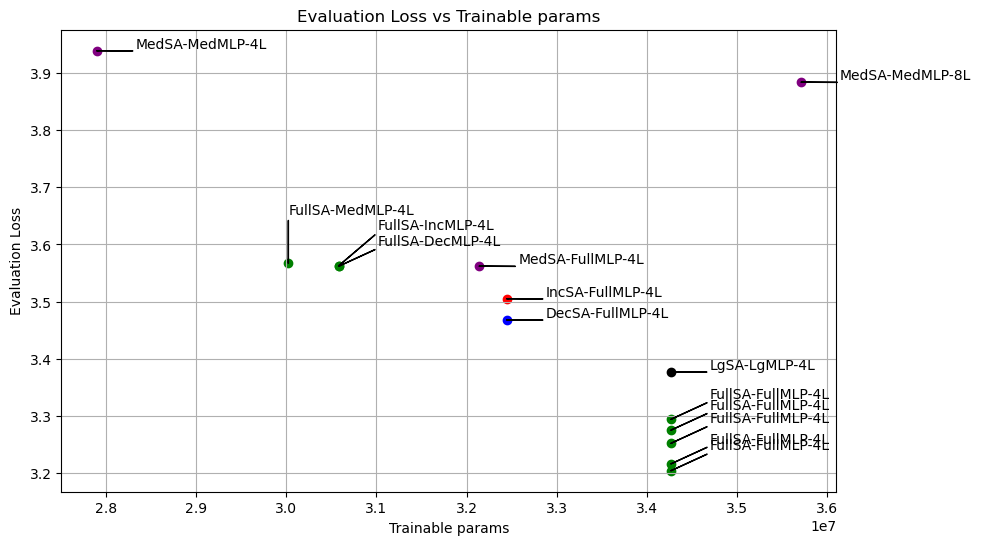

In [15]:
# Plot eval loss vs trainable params

plotlog = False
plt.figure(figsize=(10, 6))
ax = plt.gca() # Get the current Axes instance (for use with log scale)
if plotlog:
    ax.set_xscale('log') # Set the x-axis to a logarithmic scale

for i, txt in enumerate(df['Label']):
    if txt.startswith("Med"):
        color = 'purple'
        xytext=(28,2)
    elif txt.startswith("Full"):
        color = 'green'
        xytext=(28,15)
        if txt.startswith("FullSA-Med"):
            xytext=(0,35)
        if txt.startswith("FullSA-Inc"):
            xytext=(28,26)
        if txt.startswith("FullSA-Dec"):
            xytext=(28,15)
    elif txt.startswith("Inc"):
        color = 'red'
        xytext=(28,2)
    elif txt.startswith("Dec"):
        color = 'blue'
        xytext=(28,2)
    else:
        color = 'black'
        xytext=(28,2)

    plt.scatter(df['Trainable params'].iloc[i], df['eval loss @ 6k'].iloc[i], color=color)
    plt.annotate(txt, (df['Trainable params'].iloc[i], df['eval loss @ 6k'].iloc[i]), 
             xytext=xytext, textcoords='offset points',
             arrowprops=dict(facecolor='black', width=0.1, headlength=1.0, headwidth=0.0, shrink=0.))

plt.title('Evaluation Loss vs Trainable params')
plt.xlabel('Trainable params')
plt.ylabel('Evaluation Loss')
plt.grid(True)
#ax.set_xlim([0, None])
#ax.set_ylim([0, None])
plt.show()

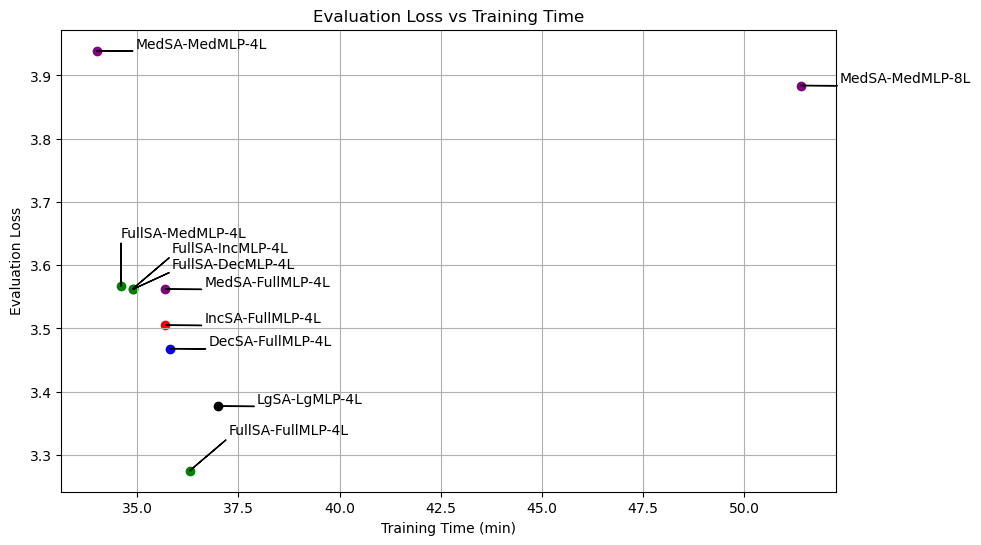

In [16]:
# Plot eval loss vs training time

plotlog = False
plt.figure(figsize=(10, 6))
ax = plt.gca() # Get the current Axes instance (for use with log scale)
if plotlog:
    ax.set_xscale('log') # Set the x-axis to a logarithmic scale

for i, txt in enumerate(df['Label']):
    if txt.startswith("Med"):
        color = 'purple'
        xytext=(28,2)
    elif txt.startswith("Full"):
        color = 'green'
        xytext=(28,26)
        if txt.startswith("FullSA-Med"):
            xytext=(0,35)
        if txt.startswith("FullSA-Inc"):
            xytext=(28,26)
        if txt.startswith("FullSA-Dec"):
            xytext=(28,15)
    elif txt.startswith("Inc"):
        color = 'red'
        xytext=(28,2)
    elif txt.startswith("Dec"):
        color = 'blue'
        xytext=(28,2)
    else:
        color = 'black'
        xytext=(28,2)

    plt.scatter(df['Training time (min)'].iloc[i], df['eval loss @ 6k'].iloc[i], color=color)
    plt.annotate(txt, (df['Training time (min)'].iloc[i], df['eval loss @ 6k'].iloc[i]), 
             xytext=xytext, textcoords='offset points',
             arrowprops=dict(facecolor='black', width=0.1, headlength=1.0, headwidth=0.0, shrink=0.))

plt.title('Evaluation Loss vs Training Time')
plt.xlabel('Training Time (min)')
plt.ylabel('Evaluation Loss')
plt.grid(True)
#ax.set_ylim([0, None])
plt.show()

## Restore from checkpoint
Note: requires restarting the kernel.

In [ ]:
set_seed(0)

from transformers import GPTNeoForCausalLM
model = GPTNeoForCausalLM.from_pretrained(keep_dir + "/" + "checkpoint-123500", device_map="auto")

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
tokenizer.pad_token = tokenizer.eos_token

device = model.device
print(device)

## Generation

In [ ]:
prompt = "Once upon a time there was"
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
output = model.generate(input_ids, max_length = 1000, num_beams=1, do_sample=True, temperature=0.9) # do_sample=True gives non-greedy sampling
output_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(output_text)